In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import model_evaluation_functions

In [2]:
%load_ext autoreload
%autoreload 2

# Load and clean prediciton data

In [3]:
df_ground_truth = pd.read_csv('../annotations/ground_truth_boat_frames_coco.csv', index_col=0, sep=';')
df_yolo_predictions = pd.read_csv('../annotations/yolov8x_full_data_with_bg_train_video_labels.csv', index_col=0, sep=';')

df_ground_truth['datetime'] = pd.to_datetime(df_ground_truth.datetime)
df_ground_truth['date'] = pd.to_datetime(df_ground_truth.datetime.dt.date, format='%Y-%m-%d')
df_yolo_predictions['datetime'] = pd.to_datetime(df_yolo_predictions['datetime'])
df_yolo_predictions['date'] = pd.to_datetime(df_yolo_predictions.datetime.dt.date, format='%Y-%m-%d')

df_ground_truth = df_ground_truth[df_ground_truth.date.isin(df_yolo_predictions.date.unique())]

print('shape of loaded data', df_ground_truth.shape, df_yolo_predictions.shape)
print('Ground truth data:')
print(df_ground_truth.groupby(['date', 'camera_id']).datetime.count())
print('YOLO predictions data:')
print(df_yolo_predictions.groupby(['date', 'camera_id']).datetime.count())

# crop bounding boxes from right side of camera 2 field of view
# df_yolo_predictions.drop(index=df_yolo_predictions[(df_yolo_predictions.camera_id == 2) & (df_yolo_predictions.x > 1800)].index, inplace=True)
# df_ground_truth.drop(index=df_ground_truth[(df_ground_truth.camera_id == 2) & (df_ground_truth.x > 1800)].index, inplace=True)

df_ground_truth.set_index('filename', inplace=True)
df_yolo_predictions.set_index('filename', inplace=True)

df_ground_truth.shape, df_yolo_predictions.shape

shape of loaded data (11492, 11) (127468, 11)
Ground truth data:
date        camera_id
2023-07-07  2            6500
2023-07-08  1            4992
Name: datetime, dtype: int64
YOLO predictions data:
date        camera_id
2023-07-07  2            105364
2023-07-08  1             22104
Name: datetime, dtype: int64


((11492, 10), (127468, 10))

In [4]:
# transform coords to xmin, ymin, xmax, ymax
df_ground_truth['xmin'] = (df_ground_truth['x'] - df_ground_truth['w']/2).astype(int)
df_ground_truth['ymin'] = (df_ground_truth['y'] - df_ground_truth['h']/2).astype(int)
df_ground_truth['xmax'] = (df_ground_truth['x'] + df_ground_truth['w']/2).astype(int)
df_ground_truth['ymax'] = (df_ground_truth['y'] + df_ground_truth['h']/2).astype(int)
df_yolo_predictions['xmin'] = (df_yolo_predictions['x'] - df_yolo_predictions['w']/2).astype(int)
df_yolo_predictions['ymin'] = (df_yolo_predictions['y'] - df_yolo_predictions['h']/2).astype(int)
df_yolo_predictions['xmax'] = (df_yolo_predictions['x'] + df_yolo_predictions['w']/2).astype(int)
df_yolo_predictions['ymax'] = (df_yolo_predictions['y'] + df_yolo_predictions['h']/2).astype(int)

In [5]:
# filter out predicitons in the bank on camera 1; use a line to define the bank in the camera 1 field of view
point1_cam01_bank = (489, 591)
point2_cam01_bank = (1499, 875)
slope_cam01_bank = (point2_cam01_bank[1] - point1_cam01_bank[1]) / (point2_cam01_bank[0] - point1_cam01_bank[0])
intercept_cam01_bank = point1_cam01_bank[1] - slope_cam01_bank * point1_cam01_bank[0]

def under_the_bank_apply(row):
    if row.camera_id == 1 and row.x >= point1_cam01_bank[0] and row.x <= point2_cam01_bank[0]:
        if row.y > (slope_cam01_bank * row.x + intercept_cam01_bank):
            return True        
    return False
        
df_yolo_predictions['under_the_bank'] = df_yolo_predictions.apply(under_the_bank_apply, axis=1)
print('How many prediction were under the bank?')
print(df_yolo_predictions['under_the_bank'].value_counts())
df_yolo_predictions = df_yolo_predictions[df_yolo_predictions.under_the_bank == False].copy()
print('YOLO predictions filtered data:')
print(df_yolo_predictions.groupby(['date', 'camera_id']).datetime.count())

How many prediction were under the bank?
under_the_bank
False    127468
Name: count, dtype: int64
YOLO predictions filtered data:
date        camera_id
2023-07-07  2            105364
2023-07-08  1             22104
Name: datetime, dtype: int64


In [6]:
df_ground_truth_cam1 = df_ground_truth[df_ground_truth['camera_id'] == 1]
df_prediction_cam_1 = df_yolo_predictions[df_yolo_predictions['camera_id'] == 1]
df_ground_truth_cam2 = df_ground_truth[df_ground_truth['camera_id'] == 2]
df_prediction_cam_2 = df_yolo_predictions[df_yolo_predictions['camera_id'] == 2]
df_ground_truth_cam1.shape, df_prediction_cam_1.shape, df_ground_truth_cam2.shape, df_prediction_cam_2.shape

((4992, 14), (22104, 15), (6500, 14), (105364, 15))

# Evaluation of precision and recall for detected frame_ids

before cam2 >1800 filtration

{'f1': 0.18191988154972444,
 'recall': 0.9799716412619638,
 'precision': 0.10026657962026005,
 'iou': 0.7545292423621479}

{'mAP_0.5_11points': 0.25194466,
 'mAP_0.5_all_points': 0.2467102,
 'mAP_0.5_0.95_101points': 0.13477196}

after cam2 >1800 filtration

{'f1': 0.24955827838277922,
 'recall': 0.97844788553835,
 'precision': 0.143017868960953,
 'iou': 0.7568439903162304}

{'mAP_0.5_11points': 0.33203986,
 'mAP_0.5_all_points': 0.3046532,
 'mAP_0.5_0.95_101points': 0.16641793}

In [7]:
df_evaluation, total_evaluation_dict = model_evaluation_functions.evaluate_model_frame_ids_score(df_ground_truth, df_yolo_predictions)
total_evaluation_dict

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:18<00:00,  8.23it/s]


{'f1': 0.1793377074237583,
 'recall': 0.9774016306274371,
 'precision': 0.09872620017365928,
 'iou': 0.0}

In [8]:
df_evaluation.to_csv('data_evaluation_full_data_with_bg_with_false_positive.csv', sep=';')

In [9]:
model_evaluation_functions.evaluate_mAP(df_ground_truth, df_yolo_predictions)

  0%|                                                                                                                                                              | 0/84 [00:00<?, ?it/s]Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data/public/svo0175/SmartHarbourDL/venv/lib/python3.11/site-packages/mean_average_precision/multiprocessing.py", line 117, in _proc_loop
    metric_fn.add(preds, gt)
  File "<string>", line 2, in add
  File "/usr/lib/python3.11/multiprocessing/managers.py", line 837, in _callmethod
    raise convert_to_error(kind, result)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:22<00:00,  3.68it/s]


{'mAP_0.5_11points': 0.0,
 'mAP_0.5_all_points': 0.0,
 'mAP_0.5_0.95_101points': 0.0}

In [10]:
df_evaluation, total_evaluation_dict = model_evaluation_functions.evaluate_model_frame_ids_score(df_ground_truth_cam1, df_prediction_cam_1)
total_evaluation_dict

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:07<00:00,  7.84it/s]


{'f1': 0.3906907650408517,
 'recall': 0.9732730263157895,
 'precision': 0.24439855446566855,
 'iou': 0.0}

In [11]:
model_evaluation_functions.evaluate_mAP(df_ground_truth_cam1, df_prediction_cam_1)

  0%|                                                                                                                                                              | 0/33 [00:00<?, ?it/s]Process Process-4:
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data/public/svo0175/SmartHarbourDL/venv/lib/python3.11/site-packages/mean_average_precision/multiprocessing.py", line 117, in _proc_loop
    metric_fn.add(preds, gt)
  6%|█████████                                                                                                                                             | 2/33 [00:00<00:01, 19.27it/s]  File "<string>", line 2, in add
  File "/usr/lib/python3.11/multiprocessing/managers.py", line 837, in _callmethod
    raise convert_to_error(kind, result)
AttributeError: 'DataFram

{'mAP_0.5_11points': 0.0,
 'mAP_0.5_all_points': 0.0,
 'mAP_0.5_0.95_101points': 0.0}

In [12]:
df_evaluation, total_evaluation_dict = model_evaluation_functions.evaluate_model_frame_ids_score(df_ground_truth_cam2, df_prediction_cam_2)
total_evaluation_dict

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:10<00:00,  9.03it/s]


{'f1': 0.12747688911839455,
 'recall': 0.9805295950155763,
 'precision': 0.06816975840074505,
 'iou': 0.0}

In [13]:
model_evaluation_functions.evaluate_mAP(df_ground_truth_cam2, df_prediction_cam_2)

  0%|                                                                                                                                                              | 0/51 [00:00<?, ?it/s]Process Process-6:
  File "<string>", line 2, in add
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data/public/svo0175/SmartHarbourDL/venv/lib/python3.11/site-packages/mean_average_precision/multiprocessing.py", line 117, in _proc_loop
    metric_fn.add(preds, gt)
  File "/usr/lib/python3.11/multiprocessing/managers.py", line 837, in _callmethod
    raise convert_to_error(kind, result)
AttributeError: 'DataFrame' object has no attribute 'append'
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

{'mAP_0.5_11points': 0.0,
 'mAP_0.5_all_points': 0.0,
 'mAP_0.5_0.95_101points': 0.0}

## Use validation part of data and only a filter images with known ground truth

In [14]:
df_ground_truth_filtered = df_ground_truth[(df_ground_truth.date == '2023-07-07') | (df_ground_truth.date == '2023-07-08')].reset_index().set_index(['filename', 'frame_id'])
df_yolo_predictions_filtered = df_yolo_predictions.reset_index().set_index(['filename', 'frame_id'])
df_yolo_predictions_filtered = df_yolo_predictions_filtered.loc[df_ground_truth_filtered.index.intersection(df_yolo_predictions_filtered.index)]
df_ground_truth_filtered.shape, df_yolo_predictions_filtered.shape

((11492, 13), (13700, 14))

In [15]:
df_ground_truth_filtered = df_ground_truth_filtered.reset_index().set_index('filename')
df_yolo_predictions_filtered = df_yolo_predictions_filtered.reset_index().set_index('filename')
df_ground_truth_filtered_cam1 = df_ground_truth_filtered[df_ground_truth_filtered['camera_id'] == 1]
df_prediction_filtered_cam_1 = df_yolo_predictions_filtered[df_yolo_predictions_filtered['camera_id'] == 1]
df_ground_truth_filtered_cam2 = df_ground_truth_filtered[df_ground_truth_filtered['camera_id'] == 2]
df_prediction_filtered_cam_2 = df_yolo_predictions_filtered[df_yolo_predictions_filtered['camera_id'] == 2]

In [16]:
df_evaluation, total_evaluation_dict = model_evaluation_functions.evaluate_model_frame_ids_score(df_ground_truth_filtered, df_yolo_predictions_filtered)
total_evaluation_dict

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:14<00:00,  5.89it/s]


{'f1': 0.9885716846681307,
 'recall': 0.9774016306274371,
 'precision': 1.0,
 'iou': 0.0}

In [17]:
model_evaluation_functions.evaluate_mAP(df_ground_truth_filtered, df_yolo_predictions_filtered)

  0%|                                                                                                                                                              | 0/84 [00:00<?, ?it/s]Process Process-8:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data/public/svo0175/SmartHarbourDL/venv/lib/python3.11/site-packages/mean_average_precision/multiprocessing.py", line 117, in _proc_loop
    metric_fn.add(preds, gt)
  File "<string>", line 2, in add
  File "/usr/lib/python3.11/multiprocessing/managers.py", line 837, in _callmethod
    raise convert_to_error(kind, result)
AttributeError: 'DataFrame' object has no attribute 'append'
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

{'mAP_0.5_11points': 0.0,
 'mAP_0.5_all_points': 0.0,
 'mAP_0.5_0.95_101points': 0.0}

In [18]:
df_evaluation, total_evaluation_dict = model_evaluation_functions.evaluate_model_frame_ids_score(df_ground_truth_filtered_cam1, df_prediction_filtered_cam_1)
total_evaluation_dict

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.35it/s]


{'f1': 0.9864555115649094,
 'recall': 0.9732730263157895,
 'precision': 1.0,
 'iou': 0.0}

In [19]:
model_evaluation_functions.evaluate_mAP(df_ground_truth_filtered_cam1, df_prediction_filtered_cam_1)

  0%|                                                                                                                                                              | 0/33 [00:00<?, ?it/s]Process Process-10:
AttributeError: 'DataFrame' object has no attribute 'append'
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  9%|█████████████▋                                                                                                                                        | 3/33 [00:00<00:01, 15.35it/s]  File "/data/public/svo0175/SmartHarbourDL/venv/lib/python3.11/site-packages/mean_average_precision/multiprocessing.py", line 117, in _proc_loop
    metric_fn.add(preds, gt)
  File "<string>", line 2, in add
  File "/usr/lib/python3.11/multiprocessing/managers.py", line 837, in _callmethod
    

{'mAP_0.5_11points': 0.0,
 'mAP_0.5_all_points': 0.0,
 'mAP_0.5_0.95_101points': 0.0}

In [20]:
df_evaluation, total_evaluation_dict = model_evaluation_functions.evaluate_model_frame_ids_score(df_ground_truth_filtered_cam2, df_prediction_filtered_cam_2)
total_evaluation_dict

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  6.23it/s]


{'f1': 0.9901690916240661,
 'recall': 0.9805295950155763,
 'precision': 1.0,
 'iou': 0.0}

In [21]:
model_evaluation_functions.evaluate_mAP(df_ground_truth_filtered_cam2, df_prediction_filtered_cam_2)

  0%|                                                                                                                                                              | 0/51 [00:00<?, ?it/s]Process Process-12:
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/data/public/svo0175/SmartHarbourDL/venv/lib/python3.11/site-packages/mean_average_precision/multiprocessing.py", line 117, in _proc_loop
    metric_fn.add(preds, gt)
  File "<string>", line 2, in add
  File "/usr/lib/python3.11/multiprocessing/managers.py", line 837, in _callmethod
    raise convert_to_error(kind, result)
AttributeError: 'DataFrame' object has no attribute 'append'
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

{'mAP_0.5_11points': 0.0,
 'mAP_0.5_all_points': 0.0,
 'mAP_0.5_0.95_101points': 0.0}

# Confidence values evaluation

In [22]:
confidence_threshold_evaluation_dict = dict()
for confidence_threshold in [0.25, 0.5, 0.75, 0.9]:
    print('Confidence threshold', confidence_threshold)
    df_evaluation, total_evaluation_dict = model_evaluation_functions.evaluate_model_frame_ids_score(df_ground_truth, df_yolo_predictions[df_yolo_predictions.confidence >= confidence_threshold])    
    print(total_evaluation_dict)
    # df_evaluation.to_csv(f'data_evaluation_conf{confidence_threshold}.csv', sep=';')
    confidence_threshold_evaluation_dict[confidence_threshold] = total_evaluation_dict

Confidence threshold 0.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:18<00:00,  8.19it/s]


{'f1': 0.1793377074237583, 'recall': 0.9774016306274371, 'precision': 0.09872620017365928, 'iou': 0.0}
Confidence threshold 0.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  7.93it/s]


{'f1': 0.5775652366209642, 'recall': 0.9258241758241759, 'precision': 0.4196930740800257, 'iou': 0.0}
Confidence threshold 0.75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:10<00:00,  8.92it/s]


{'f1': 0.6804926643723963, 'recall': 0.6658986175115207, 'precision': 0.6957407407407408, 'iou': 0.0}
Confidence threshold 0.9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 24.09it/s]

{'f1': 0.3780883806296767, 'recall': 0.23732718894009217, 'precision': 0.9292158223455933, 'iou': 0.0}


Text(0, 0.5, 'Recall')

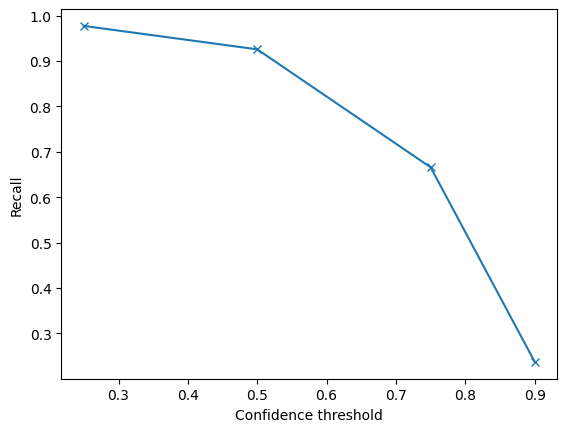

In [23]:
plt.plot(confidence_threshold_evaluation_dict.keys(), [total_evaluation_dict['recall'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], 'x-')
plt.xlabel('Confidence threshold')
plt.ylabel('Recall')

Text(0, 0.5, 'F1')

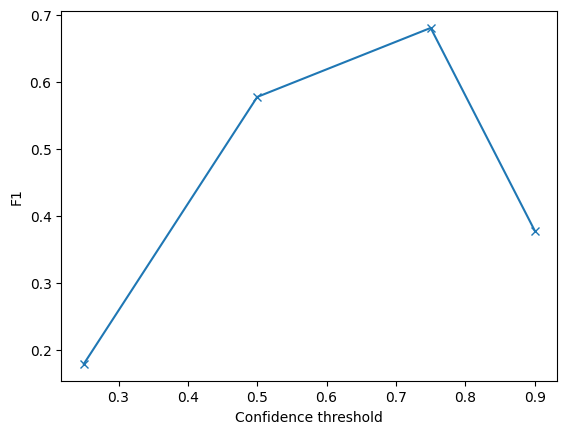

In [24]:
plt.plot(confidence_threshold_evaluation_dict.keys(), [total_evaluation_dict['f1'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], 'x-')
plt.xlabel('Confidence threshold')
plt.ylabel('F1')

Text(0, 0.5, 'Precision')

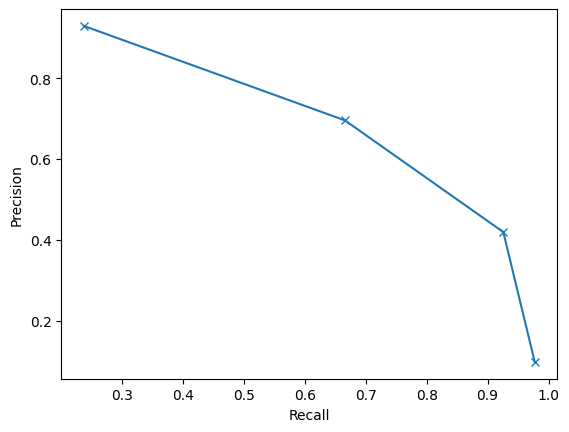

In [25]:
plt.plot([total_evaluation_dict['recall'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], [total_evaluation_dict['precision'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], 'x-')
plt.xlabel('Recall')
plt.ylabel('Precision')

Text(0, 0.5, 'IOU')

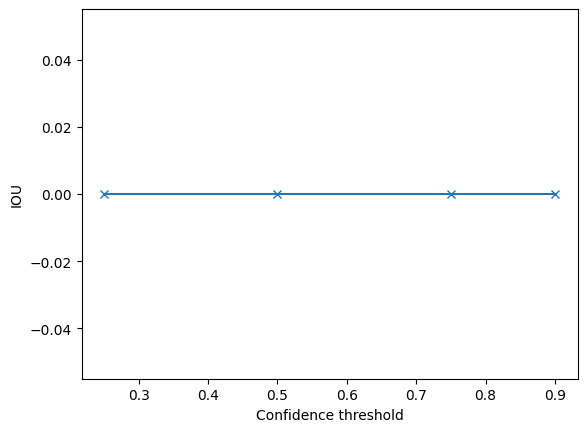

In [26]:
plt.plot(confidence_threshold_evaluation_dict.keys(), [total_evaluation_dict['iou'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], 'x-')
plt.xlabel('Confidence threshold')
plt.ylabel('IOU')